<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Разделение-на-train,-test" data-toc-modified-id="Разделение-на-train,-test-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Разделение на train, test</a></span></li><li><span><a href="#Fit-MyDecisionTree" data-toc-modified-id="Fit-MyDecisionTree-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fit MyDecisionTree</a></span></li><li><span><a href="#Predict-MyDecisionTree" data-toc-modified-id="Predict-MyDecisionTree-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Predict MyDecisionTree</a></span></li><li><span><a href="#Train-with-sklearn" data-toc-modified-id="Train-with-sklearn-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train with sklearn</a></span></li><li><span><a href="#Сравнение-метрик" data-toc-modified-id="Сравнение-метрик-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Сравнение метрик</a></span></li></ul></div>

# Задание  

1. Напишите свой алгоритм построения дерева решений для задачи бинарной классификации.  
    - критерий информативности - Энтропия Шеннона
    - критерии останова - максимальная глубина, кол-во элементов в листе, прирост энтропии < x
2. Сравните результат работы своего алгоритма с sklearn    

3. (дополнительно)  Попробуйте не делать One-Hot-Encoding для категориальных переменных, а добавить их обработку в свой алгоритм. Сравните качество работы алгоритма с предыдущим решением.

## Подготовка данных
Рассмотрим задачу "Титаник" https://www.kaggle.com/c/titanic/data. Необходимо предсказать выживет пассажир или нет.

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix 

In [2]:
# считаем данные из файла в pandas DataFrame
df = pd.read_csv("train.csv")

# зафиксируем целевую переменную и удалим ее из данных
y = df['Survived']
df.drop('Survived', axis=1, inplace=True)

In [3]:
# удалим признаки PassengerId, Name, Ticket и Cabin из данных
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# заполним пропуски в признаке Age обучающей выборки медианным значением
df['Age'].fillna(df['Age'].median(), inplace=True)

#заполним пропуски в признаке Embarked обучающей выборки самыми частыми значениями этого признака
df['Embarked'].fillna(df['Embarked'].value_counts().idxmax(), inplace=True)

#заменим категориальные признаки, используя One-Hot-Encoding
categorical = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
df_OHE = pd.concat([df, pd.get_dummies(df[categorical], columns=categorical, drop_first=True)],axis=1)

df_OHE.drop(categorical, axis=1, inplace=True)

## Разделение на train, test

In [4]:
df['Sex'].dtype == 'object'

True

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_OHE, y, test_size = 0.1, random_state = 13)

In [6]:
print ('Train: ' + str(len(X_train)))
print ('Test: ' + str(len(X_test)))

Train: 801
Test: 90


## Fit MyDecisionTree  
Напишите свою функцию построения дерева.

Структуру дерева можно задать, например, словарем следующего вида:  
```python
{'feature_name': 'Age', # название фичи 
'threshold': 20, # порог разбиения
'left': 0,  # ссылка на левое поддерево, задан доминирующий класс
'right': 1} # ссылка на правое поддерево, задан доминирующий класс
```

In [7]:
def get_thresholds(df, feature):
    df_sort = df.sort_values(by=[feature])
    values = df_sort[feature].drop_duplicates().values
    if df[feature].dtype == 'object':
        return values[:-1]
    values = (values[1:] + values[:-1]) / 2
    return values 

def get_target(df):
    """
        Функция ищет доминирующий класс во входном DataFrame
        Input - DataFrame
        Output - 0 или 1
        
        Например, в исходных данных 490 нулей и 311 единиц.
        Функция должна вернуть 0.
    """
    
    return df.target.value_counts().idxmax()


def get_entropy(target):
    """
        Функция считает энтропию заданного множества.
        Input - таргет (тип - pandas.core.series.Series)
        
        Output - значение энтропии (тип - float)
    """
    # YOUR CODE HERE
    entropy = 0
    if target.value_counts().shape[0] != 1:
        entropy = (- target.value_counts()[0] / target.shape[0] * np.log2(target.value_counts()[0] / target.shape[0]) -
                   target.value_counts()[1] / target.shape[0] * np.log2(target.value_counts()[1] / target.shape[0]))
    
    return entropy



def feature_separation(df, f_name):
    """
        Функция ищет лучшее разбиение для данной фичи.
        Input - df: DataFrame с 2 атрибутами (feature, target), 
                f_name: название фичи (для которой ищем разбиение)
                
        Output - прирост энтропии, порог разбиения
    """
    entropy_base = get_entropy(df.target)
    if entropy_base == 0:
        return (None, None)
    
    delta_entropy = 0
    threshold = None
    for thresh in get_thresholds(df, f_name):
        left = get_entropy(df['target'].loc[df[f_name] <= thresh])
        right = get_entropy(df['target'].loc[df[f_name] > thresh])
        delta_entropy_temp = (entropy_base - df.loc[df[f_name] <= thresh].shape[0] / df.shape[0] * left - 
                              df.loc[df[f_name] > thresh].shape[0] / df.shape[0] * right)
        if delta_entropy_temp > delta_entropy:
            delta_entropy = delta_entropy_temp
            threshold = thresh

    return (delta_entropy, threshold)


def best_separation(df):
    """
        Функция выбирает фичу для разбиения, которая даст максимальный прирост энтропии.
        Input - исходный DataFrame
        
        Output - словарь следующиего вида
        {'feature_name': sep_feature, 'threshold': threshold, 'groups': groups}
        
            sep_feature - название фичи для разбиения (тип - String)
            threshold - порог разбиения (тип - float)
            groups - tuple из двух поддеревьев (df_left, df_right)
    """
    
    sep_feature, threshold, groups = None, None, df
    all_features = [c for c in df.columns.tolist() if c != 'target']

    max_entropy = 0
    max_threshold = None
    max_feature = None
    for f in all_features:
        entropy, threshold = feature_separation(df, f)
        if entropy is None:
            break
        if entropy > max_entropy:
            max_entropy = entropy
            max_threshold = threshold
            max_feature = f
    sep_feature = max_feature
    threshold = max_threshold
    if entropy is None:
        groups = (df, pd.DataFrame())
    else:
        groups = (df.loc[df[sep_feature] <= threshold], df.loc[df[sep_feature] > threshold])
    
    return {'feature_name': sep_feature, 'threshold': threshold, 'groups': groups}


def split(node, max_depth, depth):
    """
        Рекурсивная функция для построения дерева
        Input - node: корень дерева
                max_depth: максимальная глубина дерева
                depth: текущая глубина дерева
    """
    
    df_left, df_right = node['groups']
    sep_feature = node['feature_name']
    del(node['groups'])
    
    # проверяем, есть ли разбиение
    if len(df_left) == 0 or len(df_right) == 0:
        node['left'] = node['right'] = get_target(df_left) if len(df_left) else get_target(df_)
        return
    
    # проверяем максимальную глубину
    if depth >= max_depth:
        node['left'], node['right'] = get_target(df_left), get_target(df_right)
        return
    
    else:
        node['left'] = best_separation(df_left)
        split(node['left'], max_depth, depth + 1)

        node['right'] = best_separation(df_right)
        split(node['right'], max_depth, depth + 1)
        
        
def fit_my_tree(df, max_depth):
    """
        Функция для обучения дерева
        Input - df: DataFrame
                max_depth: максимальная глубина дерева
    """    
    root = best_separation(df)
    split(root, max_depth, 1)

    return root

In [8]:
%%time
X_train['target'] = y_train
my_tree = fit_my_tree(X_train, 4)
X_train.drop(['target'], axis=1, inplace=True)

C:\Users\Dmitriy\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Wall time: 14.7 s


C:\Users\Dmitriy\Anaconda3\lib\site-packages\pandas\core\frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [9]:
my_tree

{'feature_name': 'Sex_male',
 'threshold': 0.5,
 'left': {'feature_name': 'Pclass_3',
  'threshold': 0.5,
  'left': {'feature_name': 'Fare',
   'threshold': 28.85625,
   'left': {'feature_name': 'Fare',
    'threshold': 28.21665,
    'left': 1,
    'right': 0},
   'right': {'feature_name': 'Age', 'threshold': 2.5, 'left': 0, 'right': 1}},
  'right': {'feature_name': 'Fare',
   'threshold': 24.808349999999997,
   'left': {'feature_name': 'Embarked_S',
    'threshold': 0.5,
    'left': 1,
    'right': 0},
   'right': {'feature_name': 'Fare',
    'threshold': 31.331249999999997,
    'left': 0,
    'right': 0}}},
 'right': {'feature_name': 'Fare',
  'threshold': 26.26875,
  'left': {'feature_name': 'Age',
   'threshold': 13.5,
   'left': {'feature_name': 'SibSp_1',
    'threshold': 0.5,
    'left': 1,
    'right': 1},
   'right': {'feature_name': 'Age', 'threshold': 32.5, 'left': 0, 'right': 0}},
  'right': {'feature_name': 'Fare',
   'threshold': 26.46875,
   'left': {'feature_name': None

## Predict MyDecisionTree  

In [10]:
def predict_raw(row, tree):
    """
        Функция предсказывает класс для 1 строки DataFrame.
        
        Input - row: строка DataFrame
                tree: обученное дерево на предыдущем шаге (тип - dict)
    """
    if tree['feature_name'] is None:
        return tree['right']
    else:
        if row[tree['feature_name']] <= tree['threshold']:
            if type(tree['left']) == dict:
                return predict_raw(row, tree['left'])
            else:
                return tree['left']
        else:
            if type(tree['right']) == dict:
                return predict_raw(row, tree['right'])
            else:
                return tree['right']
    
    
def predict_my_tree(df, tree):
    """
        Функция предсказывает класс для исходного DataFrame.
        
        Input - df: исходный DataFrame
                tree: обученное дерево на предыдущем шаге (тип - dict)
                
        Output - предсказанные классы (тип - pandas.core.series.Series)
    """      
    predict = pd.Series()   
    for index, row in df.iterrows():
        prediction = pd.Series(predict_raw(row, tree), [index])
        predict = predict.append(prediction)    
        
    return predict

In [11]:
my_pred_test = predict_my_tree(X_test, my_tree)
my_pred_train = predict_my_tree(X_train, my_tree)

C:\Users\Dmitriy\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


## Train with sklearn 

Обучите дерево, используя библиотеку sklearn. Задайте те же параметры, что и при обучении своего дерева.  

Сравните метрики и попробуйте улучшить ваше дерево.

In [12]:
from sklearn import tree

In [13]:
%%time
clf_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=4)

# обучаем дерево
clf_tree.fit(X_train, y_train)

# предсказание на тестовой и обучающей выборках
y_pred_test = clf_tree.predict(X_test)
y_pred_train = clf_tree.predict(X_train)

Wall time: 8.99 ms


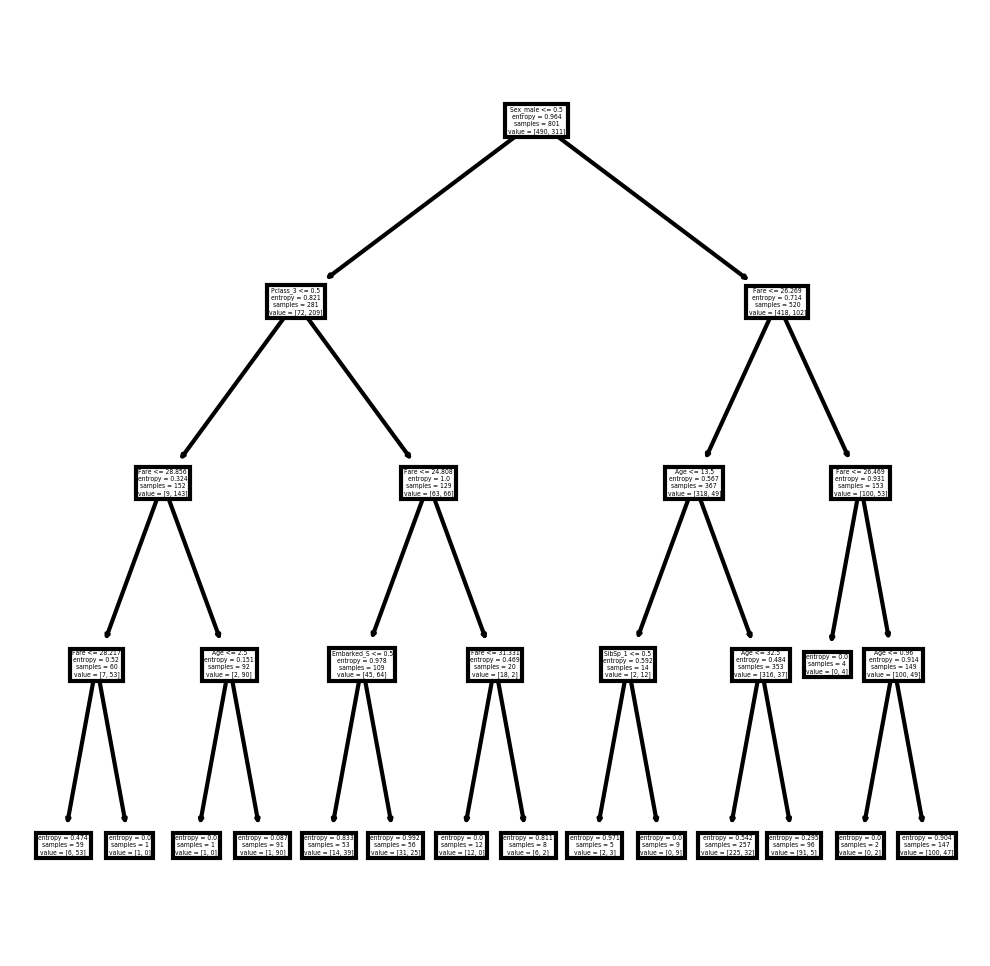

In [14]:
from matplotlib import pyplot as plt
#Отрисовать дерево можно вот так:   
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf_tree, feature_names = X_train.columns);

## Сравнение метрик

In [15]:
# метрики при обучении, используя библиотеку sklearn
skl_roc_train = roc_auc_score(y_train, y_pred_train)
skl_roc_test = roc_auc_score(y_test, y_pred_test)

# метрики при обучении, используя собственный алгоритм
my_roc_train = roc_auc_score(y_train, my_pred_train)
my_roc_test = roc_auc_score(y_test, my_pred_test)

In [16]:
print(my_roc_test)

0.7895024603608528


In [17]:
print(skl_roc_test)

0.7895024603608528


In [18]:
#assert abs(my_roc_test - 0.6) >= 0.2
assert 0.98 <= skl_roc_test / my_roc_test <= 1.02

# Алгоритм с поддержкой категориальных признаков

In [23]:
df

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,3,female,28.0,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


In [19]:
from sklearn.model_selection import train_test_split

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(df, y, test_size = 0.1, random_state = 13)

In [20]:
%%time
X_train_cat['target'] = y_train
my_tree_cat = fit_my_tree(X_train_cat, 4)
X_train_cat.drop(['target'], axis=1, inplace=True)

C:\Users\Dmitriy\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Wall time: 14.4 s


C:\Users\Dmitriy\Anaconda3\lib\site-packages\pandas\core\frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [21]:
my_pred_test_cat = predict_my_tree(X_test_cat, my_tree_cat)

C:\Users\Dmitriy\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [22]:
 roc_auc_score(y_test_cat, my_pred_test_cat)

0.7895024603608528

результаты совпали